# Deconvolution Example

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import deconvolve as dcvl

## Simulate fMRI time-series

In [4]:
# set simulation parameters
TR = 1 # duration of TR
endBuffer = 0 # null period following sequence specified in par file
tau = 2 # determines shape of simulated hemodynamic response function (HRF)
noiseSD = 0.1 # SD of guassian noise added to simulated time series
nTimes = 20 # number of TRs to simulate the HRF across
nRuns = 3 # number of runs/scans to concatenate (between 1 and 10)

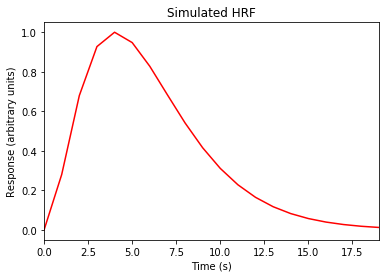

In [5]:
# make HRF
t = np.arange(0,nTimes,TR)
HRF = TR*(t/tau)**2 * np.exp(-t/tau) / 2*tau
HRF = HRF/np.max(HRF)

plt.plot(HRF,'r')
plt.title('Simulated HRF')
plt.xlabel('Time (s)')
plt.ylabel('Response (arbitrary units)')
plt.xlim([0,nTimes-1]);

In [6]:
# get run information from paradigm files

file_dir = os.getcwd() + '/example_paradigm_files/'
run_numbers = list(range(1,nRuns+1))
run_names = dcvl.create_parfile_list(run_numbers,'par')
stimTimes, cond, runNum, totalDur = dcvl.compile_paradigm_files(file_dir,run_names,endBuffer)
nRuns = len(np.unique(runNum)) 
nConds = len(np.unique(cond))
nTRs = int(totalDur/TR)

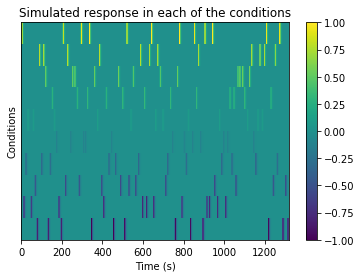

In [7]:
# generate design matrix

designMatrix, condIdx = dcvl.buildDesignMatrix_betaEst(cond,stimTimes,runNum,HRF,include_runterms=0)

cond_amps = np.linspace(-1,1,nConds) # amplitude of response in each of the conditions

plt.figure()
plt.imshow((cond_amps*designMatrix).T,origin='lower',cmap=pl.cm.viridis,aspect='auto')
plt.xlabel('Time (s)')
plt.ylabel('Conditions')
plt.yticks([])
plt.colorbar();
plt.title('Simulated response in each of the conditions');

Simulated fMRI time-series


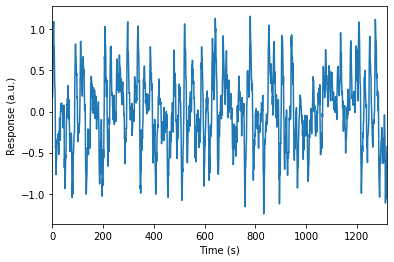

In [8]:
# simulate fMRI time-series with gaussian noise added

fMRI = np.matmul(designMatrix,cond_amps) + np.random.standard_normal(nTRs)*noiseSD

plt.figure()
plt.plot(range(nTRs), fMRI)
plt.xlabel('Time (s)')
plt.xlim([0,nTRs])
plt.ylabel('Response (a.u.)')
print('Simulated fMRI time-series')

# Estimating beta weights
Estimate beta weights for each condition (assuming an HRF).

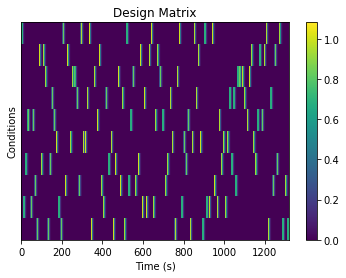

In [9]:
# build design matrix

designMatrix, condIdx = dcvl.buildDesignMatrix_betaEst(cond,stimTimes,runNum,HRF)

plt.figure()
plt.imshow((designMatrix).T,origin='lower',cmap=pl.cm.viridis,aspect='auto')
plt.xlabel('Time (s)')
plt.ylabel('Conditions')
plt.yticks([])
plt.colorbar()
plt.title('Design Matrix');

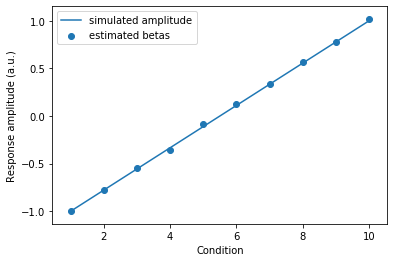

In [11]:
# solve GLM to estimate beta weights

designMatrix_pinv = np.linalg.pinv(designMatrix) 
betas_est = np.dot(designMatrix_pinv,fMRI)

plt.figure()
plt.plot(np.arange(1,nConds+1),cond_amps)
plt.scatter(np.arange(1,nConds+1),betas_est)
plt.xlabel('Condition')
plt.ylabel('Response amplitude (a.u.)')
plt.legend(['simulated amplitude','estimated betas']);

## Full deconvolution
Deconvolve the full HRF for each condition.

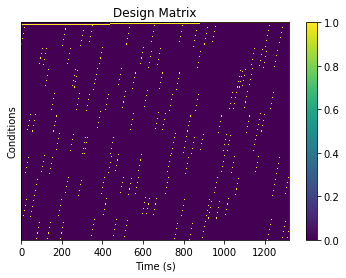

In [12]:
# build design matrix

nTimes = 20  # number of time points to deconvolve
designMatrix, condIdx = dcvl.buildDesignMatrix_deconvolve(cond, stimTimes, runNum, nTimes, include_runterms=1)

plt.figure()
plt.imshow(designMatrix.T,origin='lower',cmap=pl.cm.viridis,aspect='auto')
plt.xlabel('Time (s)')
plt.ylabel('Conditions')
plt.yticks([])
plt.colorbar()
plt.title('Design Matrix');

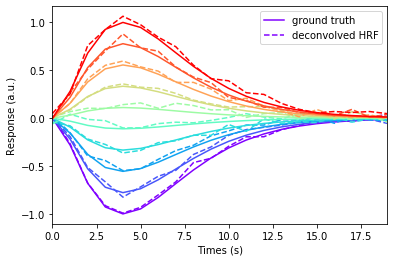

In [16]:
# solve GLM to estimate HRFs

designMatrix_pinv = np.linalg.pinv(designMatrix) 
betas_est = np.dot(designMatrix_pinv,fMRI)

deconvolvedResp = np.zeros([nConds,nTimes])
for c in range(nConds):
   deconvolvedResp[c,:] = betas_est[condIdx == c+1]

plt.figure()
cmap = pl.cm.rainbow(np.linspace(0,1,nConds))
for c in range(nConds):
    ground_truth = cond_amps[c]*HRF
    plt.plot(range(nTimes),ground_truth,color=cmap[c])
    plt.plot(range(nTimes),deconvolvedResp[c,:],color=cmap[c],linestyle='--')
plt.xlim([0,nTimes-1])
plt.xlabel('Times (s)')
plt.ylabel('Response (a.u.)')
plt.legend(['ground truth','deconvolved HRF']);